In [125]:
# все импорты
import numpy as np
import pandas as pd

# для графиков
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('figure', figsize = (10,10))

# статистика
from scipy.stats import normaltest # критерий согласия Пирсона для проверки распределения на нормальность
from scipy.stats import mannwhitneyu # критерий проверки различий двух выборок (категориальный+количественный)
from scipy.stats import chi2_contingency

# решение проблемы несбалансированности выборок
from imblearn.over_sampling import SMOTE

In [126]:
# первый взгляд на данные
df = pd.read_csv('Downloads/heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


The dataset contains 18 variables (9 booleans, 5 strings and 4 decimals). In machine learning projects, "HeartDisease" can be used as the explonatory variable, but note that the classes are heavily unbalanced.

HeartDisease
Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI)

BMI
Body Mass Index (BMI)

Smoking
Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes]

AlcoholDrinking
Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week

Stroke
(Ever told) (you had) a stroke?

PhysicalHealth
Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? (0-30 days)

MentalHealth
Thinking about your mental health, for how many days during the past 30 days was your mental health not good? (0-30 days)

DiffWalking
Do you have serious difficulty walking or climbing stairs?

Sex
Are you male or female?

AgeCategory
Fourteen-level age category

Race
Imputed race/ethnicity value

Diabetic
(Ever told) (you had) diabetes?

PhysicalActivity
Adults who reported doing physical activity or exercise during the past 30 days other than their regular job

GenHealth
Would you say that in general your health is...

SleepTime
On average, how many hours of sleep do you get in a 24-hour period?

Asthma
(Ever told) (you had) asthma?

KidneyDisease
Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?

SkinCancer
(Ever told) (you had) skin cancer?

In [127]:
df.shape

(319795, 18)

# Первичная предобработка данных.

### 1. Обработка пропущенных значений (если они, конечно, есть)

In [128]:
df.isna().sum()
# Пропущенных значений нет. Чудесно:>

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

### 2. Работаем с типами данных.

In [129]:
df.dtypes
# Так, вот тут будет веселье. Начнем!!

HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

In [130]:
# Посмотрим на признаки типа object, обычно с ними больше всего работы
# Так, предлагаю сразу создать список признаков с двумя возможными категориями, чтобы потом поменять их на тип boolean
to_boolean = []
for i in df.select_dtypes(include='object'):
    print('-'*15,'\n', i)
    print('Количество уникальных элементов:', len(df[i].unique()))
    print('Уникальные элементы:', df[i].unique())
    if len(df[i].unique()) == 2:
        to_boolean.append(i)
print('\n\nПризнаки с двумя категориями: ', to_boolean)

--------------- 
 HeartDisease
Количество уникальных элементов: 2
Уникальные элементы: ['No' 'Yes']
--------------- 
 Smoking
Количество уникальных элементов: 2
Уникальные элементы: ['Yes' 'No']
--------------- 
 AlcoholDrinking
Количество уникальных элементов: 2
Уникальные элементы: ['No' 'Yes']
--------------- 
 Stroke
Количество уникальных элементов: 2
Уникальные элементы: ['No' 'Yes']
--------------- 
 DiffWalking
Количество уникальных элементов: 2
Уникальные элементы: ['No' 'Yes']
--------------- 
 Sex
Количество уникальных элементов: 2
Уникальные элементы: ['Female' 'Male']
--------------- 
 AgeCategory
Количество уникальных элементов: 13
Уникальные элементы: ['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29']
--------------- 
 Race
Количество уникальных элементов: 6
Уникальные элементы: ['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic']
--------------- 
 Diabetic
Количество уникальных элемен

In [131]:
# тут много булевых признаков, которые pandas считает объектами из-за того, что вместо 0 и 1 там Yes и No
# сразу создадим маленький словарик, чтобы упростить себе жизнь
yn_to_bool = {'No':0, 'Yes':1}

# пол пока что не буду переводить в булевский признак, чтобы было легче интерпретировать результаты анализа
to_boolean.remove('Sex')

for i in to_boolean:
    df[i] = df[i].map(yn_to_bool).astype('bool')

In [132]:
#Все остальные объекты на самом деле категории, поменяем им тип
for i in df.select_dtypes(include='object'):
    df[i] = df[i].astype('category')

In [133]:
df.dtypes
#Прелесть:) 

HeartDisease            bool
BMI                  float64
Smoking                 bool
AlcoholDrinking         bool
Stroke                  bool
PhysicalHealth       float64
MentalHealth         float64
DiffWalking             bool
Sex                 category
AgeCategory         category
Race                category
Diabetic            category
PhysicalActivity        bool
GenHealth           category
SleepTime            float64
Asthma                  bool
KidneyDisease           bool
SkinCancer              bool
dtype: object

# Первичная предобработка данных завершена! Теперь можно посмотреть, как каждый из признаков влияет на таргет (HeartDisease)

In [134]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,False,16.60,True,False,False,3.0,30.0,False,Female,55-59,White,Yes,True,Very good,5.0,True,False,True
1,False,20.34,False,False,True,0.0,0.0,False,Female,80 or older,White,No,True,Very good,7.0,False,False,False
2,False,26.58,True,False,False,20.0,30.0,False,Male,65-69,White,Yes,True,Fair,8.0,True,False,False
3,False,24.21,False,False,False,0.0,0.0,False,Female,75-79,White,No,False,Good,6.0,False,False,True
4,False,23.71,False,False,False,28.0,0.0,True,Female,40-44,White,No,True,Very good,8.0,False,False,False


## 1. Разберемся с числовыми признаками.

In [135]:
# Посмотрим на общую картину
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


--------------- 
 BMI
Проверка на нормальность показывает, что вероятность случайно получить такое отклонение при условии нормальности распределения равна:  0.0
Отклоняем гипотезу о нормальном распределении признака
--------------- 
 PhysicalHealth
Проверка на нормальность показывает, что вероятность случайно получить такое отклонение при условии нормальности распределения равна:  0.0
Отклоняем гипотезу о нормальном распределении признака
--------------- 
 MentalHealth
Проверка на нормальность показывает, что вероятность случайно получить такое отклонение при условии нормальности распределения равна:  0.0
Отклоняем гипотезу о нормальном распределении признака
--------------- 
 SleepTime
Проверка на нормальность показывает, что вероятность случайно получить такое отклонение при условии нормальности распределения равна:  0.0
Отклоняем гипотезу о нормальном распределении признака


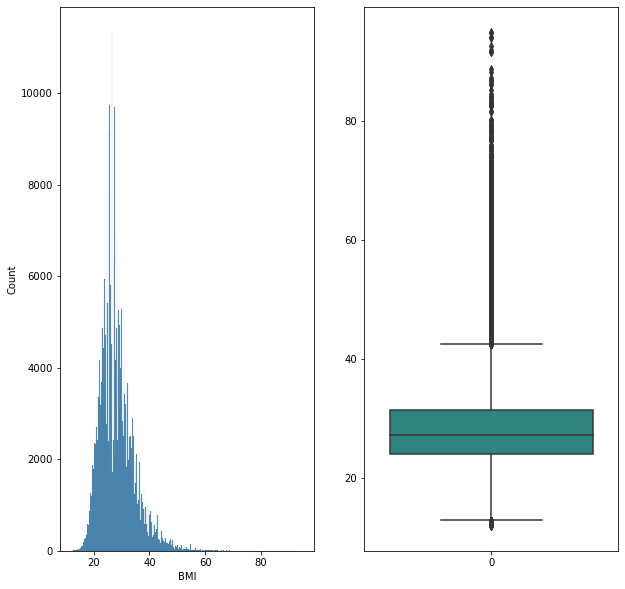

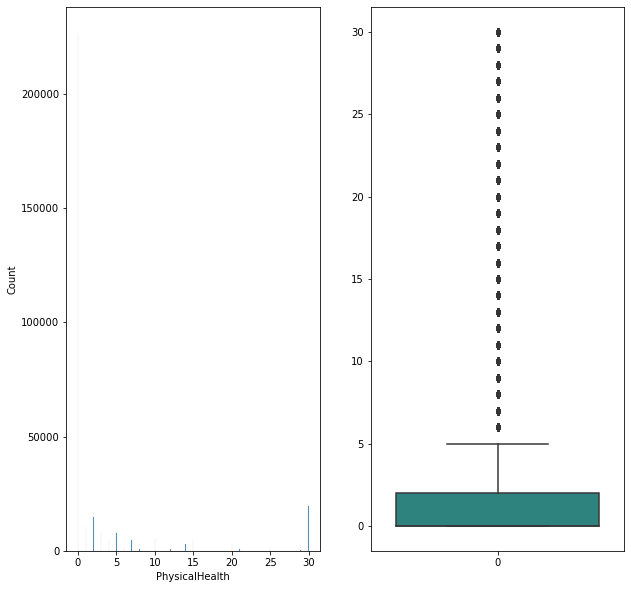

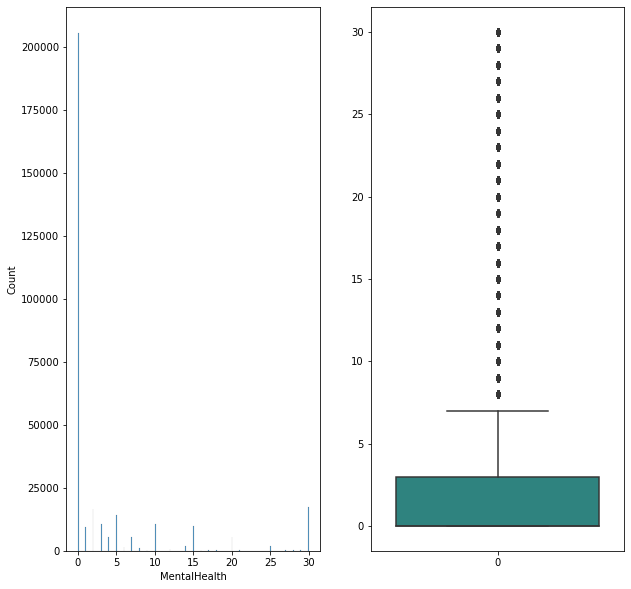

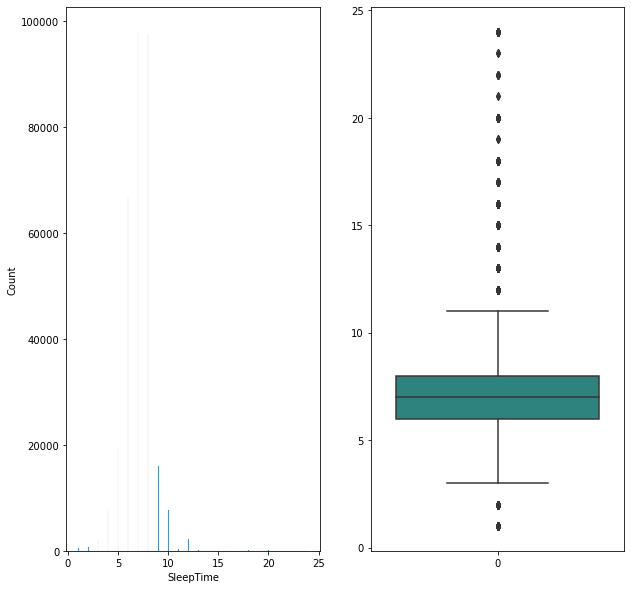

In [136]:
# Сначала проверим наши колличественные признаки на нормальность и просто посмотрим на их распределение

def analysis_intself(column):
    print('-'*15,'\n', column)
    _, axes = plt.subplots(1,2)
    #графики для примерной оценки распределения
    sns.histplot(df[column], ax=axes[0], palette='viridis')
    sns.boxplot(data = df[column], palette='viridis' ,ax=axes[1])
    _, p = normaltest(df[column])
    print('Проверка на нормальность показывает, что вероятность случайно получить такое отклонение при условии нормальности распределения равна: ', p)
    if p>0.05:
        print('Принимаем гипотезу о нормальном распределении признака')
    else:
        print('Отклоняем гипотезу о нормальном распределении признака')
    
for i in df.select_dtypes(include='number'):
    analysis_intself(i)

In [137]:
# Похоже, что признаки, отнесенные пандасом к числовым могут на самом деле быть категориальными, посмотрим на них
for i in df.select_dtypes(include='number'):
    print('-'*15,'\n', i)
    if i!='BMI':
        df[i] = df[i].astype('int')
    print('Количество уникальных элементов:', len(df[i].unique()))
    print('Уникальные элементы:', df[i].unique())
# Ну для категорий тут многовато уникальных значений, поэтому оставим, как есть
# Получается, что распределение BMI и Продолжительности сна похоже на нормальное за исключением выбросов и смещений (потом можно будет их прологарифмировать)

--------------- 
 BMI
Количество уникальных элементов: 3604
Уникальные элементы: [16.6  20.34 26.58 ... 62.42 51.46 46.56]
--------------- 
 PhysicalHealth
Количество уникальных элементов: 31
Уникальные элементы: [ 3  0 20 28  6 15  5 30  7  1  2 21  4 10 14 18  8 25 16 29 27 17 24 12
 23 26 22 19  9 13 11]
--------------- 
 MentalHealth
Количество уникальных элементов: 31
Уникальные элементы: [30  0  2  5 15  8  4  3 10 14 20  1  7 24  9 28 16 12  6 25 17 18 21 29
 22 13 23 27 26 11 19]
--------------- 
 SleepTime
Количество уникальных элементов: 24
Уникальные элементы: [ 5  7  8  6 12  4  9 10 15  3  2  1 16 18 14 20 11 13 17 24 19 21 22 23]


### Посмотрим на корреляции:

,BMI,PhysicalHealth,MentalHealth,SleepTime
BMI,1.000000,0.109788,0.064131,-0.051822
PhysicalHealth,0.109788,1.000000,0.287987,-0.061387
MentalHealth,0.064131,0.287987,1.000000,-0.119717
SleepTime,-0.051822,-0.061387,-0.119717,1.000000


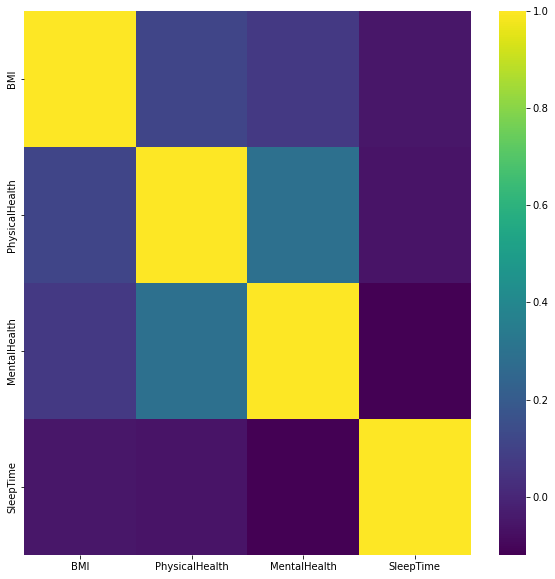

In [138]:
sns.heatmap(df.select_dtypes(include='number').corr(), cmap='viridis')
df.select_dtypes(include='number').corr()
# На первый взгляд наши числовые признаки слабо скореллированны друг с другом

### Посмотрим на выбросы.

In [139]:
# Так, окей, мне кажется немного странным тот факт, что кто-то в среднем спит 24 часа в сутки 0-0
# Посмотрим на этих сверхлюдей
df.loc[df['SleepTime']>=15]

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
10,True,34.30,True,False,False,30,0,True,Male,60-64,White,Yes,False,Poor,15,True,False,False
262,False,32.78,False,False,False,0,0,False,Male,70-74,Black,No,False,Very good,15,False,False,False
618,False,46.68,False,False,False,30,15,True,Female,55-59,Black,No,True,Good,16,False,False,False
718,False,19.79,True,False,True,30,10,True,Female,60-64,Black,No,False,Poor,18,True,False,False
733,False,30.51,False,False,False,5,0,False,Female,60-64,Black,Yes,True,Good,15,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314478,False,23.78,True,False,False,0,1,False,Female,50-54,Other,No,False,Good,16,False,False,False
314642,False,30.09,False,False,False,30,30,True,Female,50-54,Other,No,False,Fair,15,True,False,False
315653,False,27.91,False,False,False,3,5,False,Male,40-44,Hispanic,No,True,Good,15,True,False,False
315663,True,31.09,False,False,True,0,0,True,Female,80 or older,Hispanic,Yes,False,Good,15,True,False,False


In [140]:
print(df.loc[df['SleepTime']>=15].describe())
print('-'*50)
print(df.loc[df['SleepTime']>=15].describe(include='category'))
print('-'*50)
# кажется, тут или побитые данные, или опрошенные - приколисты, потому что особой закономерности я не наблюдаю
# посмотрим, какой процент от данных они оставляют
print('Процент людей, спящих более 15 часов в сутки: ', round(df.loc[df['SleepTime']>=15].shape[0]*100/df.shape[0], 2))

              BMI  PhysicalHealth  MentalHealth   SleepTime
count  659.000000      659.000000    659.000000  659.000000
mean    30.009454       11.030349      9.383915   16.949924
std      8.342048       12.990960     12.310933    2.311379
min     12.530000        0.000000      0.000000   15.000000
25%     24.210000        0.000000      0.000000   15.000000
50%     28.700000        3.000000      0.000000   16.000000
75%     33.875000       30.000000     20.000000   18.000000
max     83.000000       30.000000     30.000000   24.000000
--------------------------------------------------
           Sex  AgeCategory   Race Diabetic GenHealth
count      659          659    659      659       659
unique       2           13      6        4         5
top     Female  80 or older  White       No      Good
freq       376           91    349      449       185
--------------------------------------------------
Процент людей, спящих более 15 часов в сутки:  0.21


In [141]:
# Посмотрим на людей, которые спят меньше 3 часов в сутки
print(df.loc[df['SleepTime']<=3].describe())
print('-'*50)
print(df.loc[df['SleepTime']<=3].describe(include='category'))
print('-'*50)
print('Процент людей, спящих менее 3 часов в сутки: ', round(df.loc[df['SleepTime']<=3].shape[0]*100/df.shape[0], 2))

               BMI  PhysicalHealth  MentalHealth    SleepTime
count  3331.000000     3331.000000   3331.000000  3331.000000
mean     29.324011        9.944461     10.288502     2.432603
std       7.761050       12.549155     12.497733     0.759251
min      12.840000        0.000000      0.000000     1.000000
25%      24.020000        0.000000      0.000000     2.000000
50%      27.980000        2.000000      2.000000     3.000000
75%      33.000000       25.000000     25.000000     3.000000
max      91.550000       30.000000     30.000000     3.000000
--------------------------------------------------
           Sex AgeCategory   Race Diabetic GenHealth
count     3331        3331   3331     3331      3331
unique       2          13      6        4         5
top     Female       60-64  White       No      Good
freq      1678         383   2280     2525       901
--------------------------------------------------
Процент людей, спящих менее 3 часов в сутки:  1.04


In [142]:
# В принципе, процент выбросов очень маленький, поэтому можно просто удалить эти данные
# Удалю эти записи из таблицы двумя разными способами, потому что могу))))))
df.drop(np.where(df['SleepTime'] > 15)[0], inplace=True)
df = df.loc[df['SleepTime'] > 3]

На этом сражение с выбросами объявляю законченным, т.к:

1. ИМТ действительно может быть очень большим (все-таки у человечества проблемы с ожирением, но можно будет попробовать создать категориальную фичу, отвечающую за массу тела (превышение, сильное превышение, недостаток или норма))
2. Человек действительно может испытывать физический/ментальный стресс в течение всего месяца, хотя там достаточно маленькие средние значения

## 2. Анализ номинальных (категориальных) и булевых признаков.

In [143]:
# Стандартный взгляд на общую картину
df.describe(include=['bool', 'category'])

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
count,315994,315994,315994,315994,315994,315994,315994,315994,315994,315994,315994,315994,315994,315994
unique,2,2,2,2,2,2,13,6,4,2,5,2,2,2
top,False,False,False,False,False,Female,65-69,White,No,True,Very good,False,False,False
freq,289239,186036,294517,304292,273037,165861,33798,242700,266812,245549,113099,273991,304515,286479


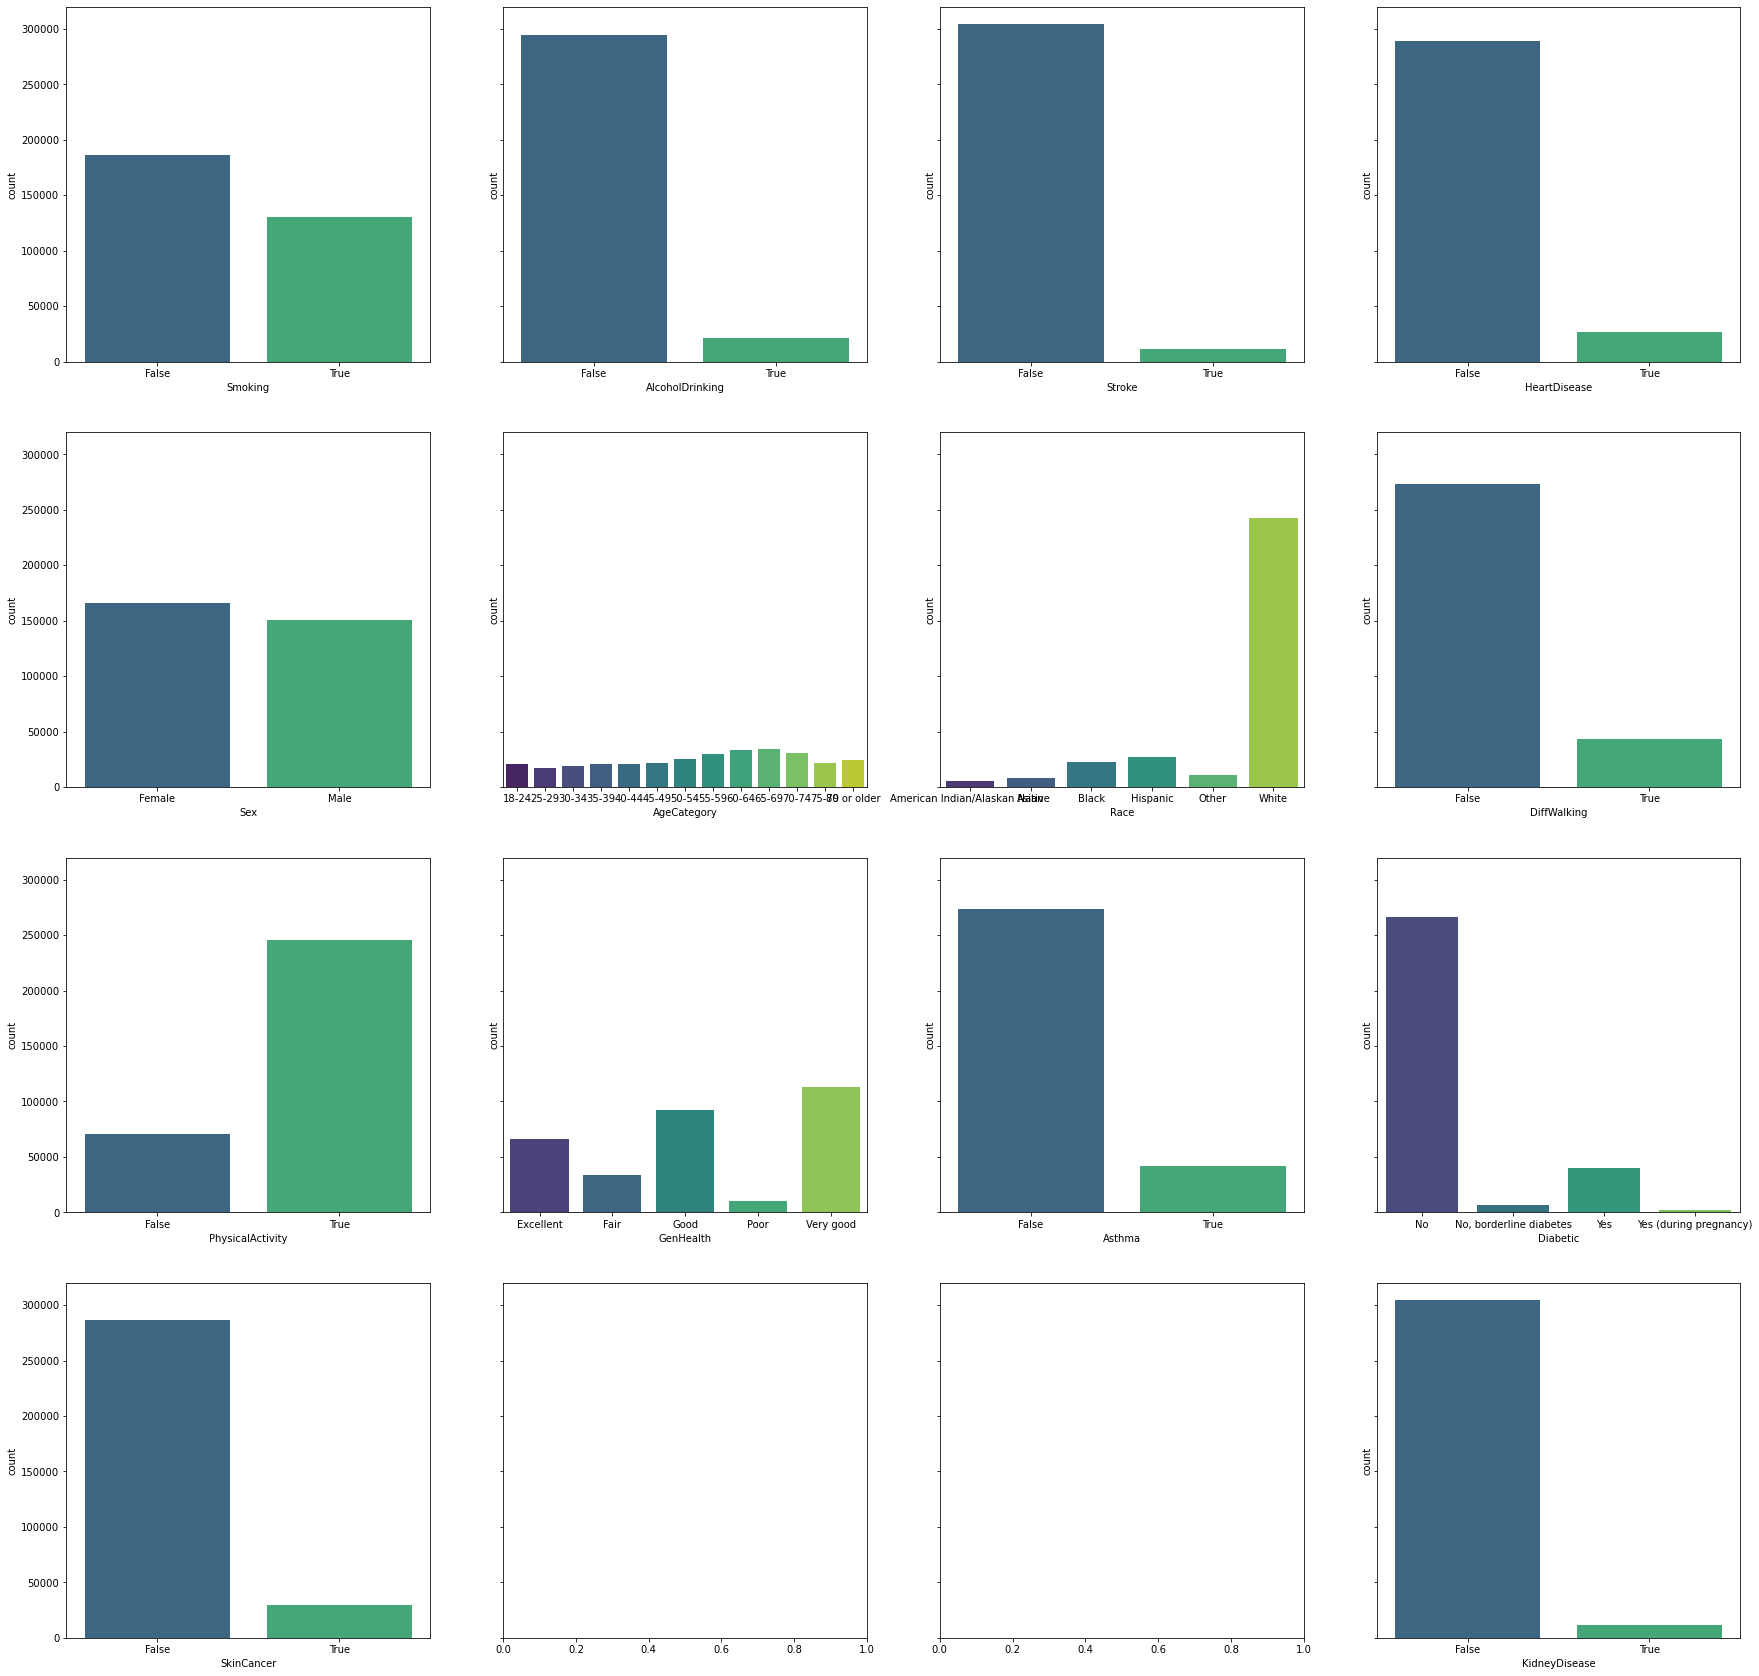

In [144]:
# Ну тут особо не развернешься. Посмотрим только на распределение разных признаков в выборке.
_, axes = plt.subplots(4, 4, figsize=(30, 30), sharey=True)
i = 0
for col in df.select_dtypes(exclude='number'):
    sns.countplot(x=df[col], ax=axes[i//4, i%4-1], palette='viridis')
    i+=1
# Оооох, данные не особо сбалансированны:( Анализировать придется осторожно

#### Напишем функцию, которая будет решать проблему несбалансированности классов (на всякий случай)

In [145]:
def disbalance(target, col):
    sm = SMOTE(random_state=12)
    x = np.array(df[col]).reshape(-1,1)
    y = df[target]
    x_resampled, y_resampled = sm.fit_resample(x, y)
    x_resampled_real = []
    for i in x_resampled: x_resampled_real.extend(i)
    return x_resampled_real, y_resampled

## 3. Посмотрим, влияют ли количественные принаки на таргет:)

In [146]:
# Наш таргет представляет собой обычный булевый признак, поэтому средние мы будем сравнивать у двух групп
# Соответсвенно будем смотреть на результаты критерия манна-уитни 

def analysis_intbool(column, target):
    
    # посмотрим на показатели описательной статистики
    print(df.groupby(target)[column].describe())
    print('-'*30)
    
#     # разбираемся с проблемой несбалансированности
#     yes = df.loc[df[target]==True, :][column]
#     no = df.loc[df[target]==False, :][column]
#     if (len(yes)//len(no) >= 2) or (len(no)//len(yes) >= 2):
#         x_resampled, y_resampled = disbalance(target, column)
#         analysis_df = pd.DataFrame(data={column:x_resampled, target:y_resampled})
#     else:
#         analysis_df = df.copy()
        
    # рисуем графики, чтобы посмотреть, как визуально отличаются распределения
    _, axes = plt.subplots(1,2, figsize=(20,10))
    sns.boxplot(y=df[column], x=df[target], ax=axes[0], palette='viridis')
    sns.histplot(x=df[column], hue=df[target], ax=axes[1], palette='viridis')
    
    # проводим тест манна-уитни, т.к. количественный признак распределен ненормально
    u, p = mannwhitneyu(df.loc[df[target]==True,column], df.loc[df[target]==False,column])
    print(f'P-value: {p}; U-crit: {u}')
    if p>0.005:
        print('Принимаем гипотезу об отсутствии различий распределений (в частности, среднего значения)')
    else:
        print('Принимаем гипотезу о !НАЛИЧИИ! различий распределений (в частности, среднего значения)')    

                 count       mean       std    min    25%    50%    75%    max
HeartDisease                                                                  
False         289239.0  28.213508  6.308942  12.02  23.89  27.26  31.32  94.85
True           26755.0  29.378402  6.516313  12.21  25.06  28.34  32.61  83.33
------------------------------
P-value: 1.4876801735659652e-226; U-crit: 4328006551.0
Принимаем гипотезу о !НАЛИЧИИ! различий распределений (в частности, среднего значения)


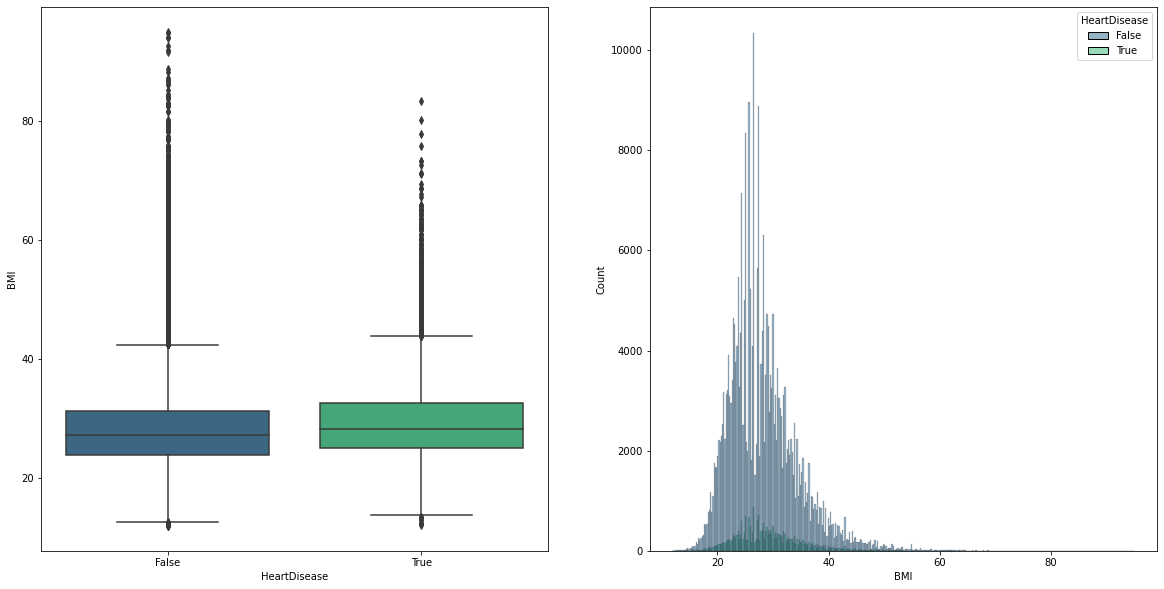

In [147]:
analysis_intbool('BMI', 'HeartDisease')

                 count      mean       std  min  25%  50%  75%   max
HeartDisease                                                        
False         289239.0  3.765357  7.741691  0.0  0.0  0.0  3.0  30.0
True           26755.0  4.451691  8.968315  0.0  0.0  0.0  3.0  30.0
------------------------------
P-value: 8.973428707794206e-05; U-crit: 3821464379.5
Принимаем гипотезу о !НАЛИЧИИ! различий распределений (в частности, среднего значения)


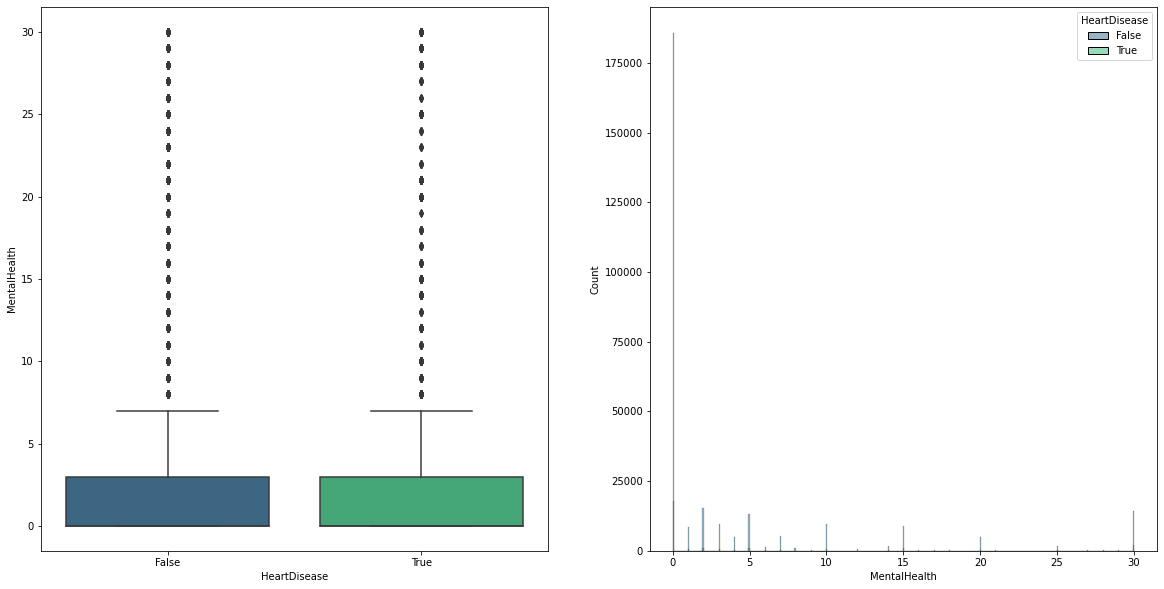

In [148]:
analysis_intbool('MentalHealth','HeartDisease')

                 count      mean        std  min  25%  50%   75%   max
HeartDisease                                                          
False         289239.0  2.891650   7.304911  0.0  0.0  0.0   1.0  30.0
True           26755.0  7.617642  11.377306  0.0  0.0  0.0  14.0  30.0
------------------------------
P-value: 0.0; U-crit: 4767342629.0
Принимаем гипотезу о !НАЛИЧИИ! различий распределений (в частности, среднего значения)


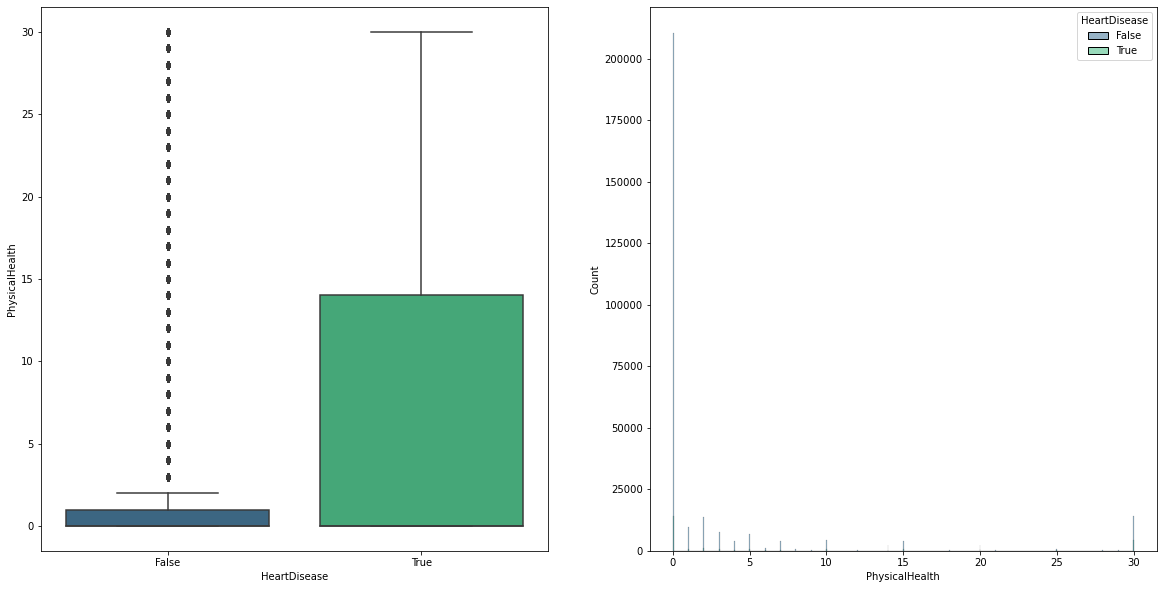

In [149]:
analysis_intbool('PhysicalHealth','HeartDisease')

                 count      mean       std  min  25%  50%  75%   max
HeartDisease                                                        
False         289239.0  7.124541  1.266928  4.0  6.0  7.0  8.0  15.0
True           26755.0  7.194020  1.554447  4.0  6.0  7.0  8.0  15.0
------------------------------
P-value: 1.4012123171333434e-11; U-crit: 3962381962.5
Принимаем гипотезу о !НАЛИЧИИ! различий распределений (в частности, среднего значения)


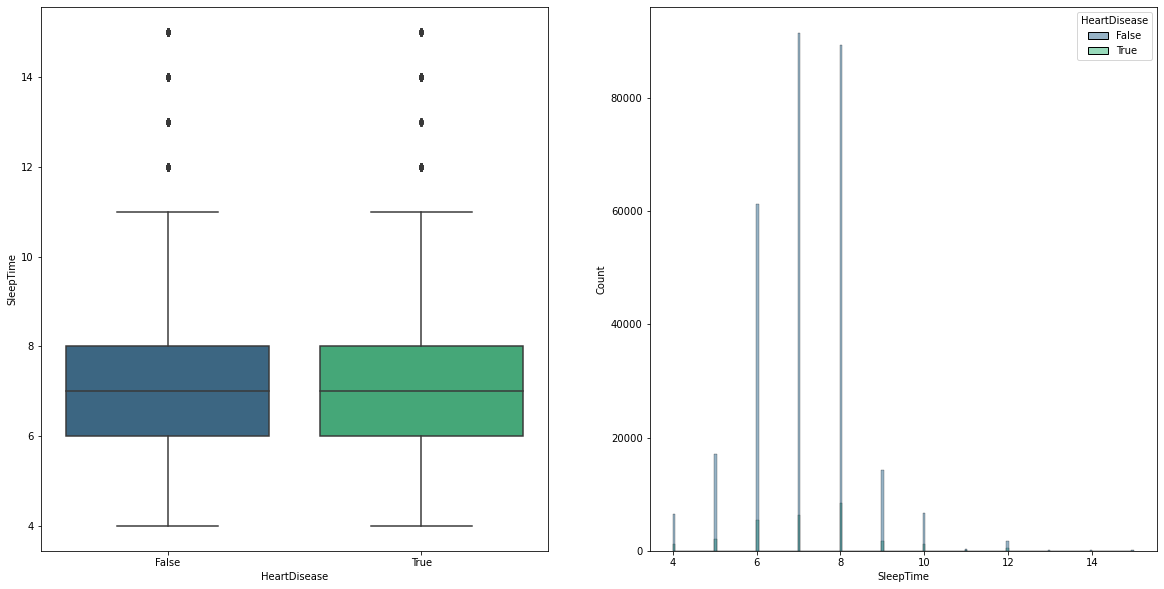

In [150]:
analysis_intbool('SleepTime','HeartDisease')

## 4. Теперь посмотрим на влияние номинальных признаков на таргет.

In [151]:
def chi_test(col1, col2):
    
    print('-'*50)
    print(f'АНАЛИЗ ВЗАИМОСВЯЗИ ПРИЗНАКОВ {col1}, {col2}')
    print('-'*50)
    
    table= pd.crosstab(df[col1], df[col2])
    test = chi2_contingency(table)
    if test[1]>=0.05:
        print("Существенных различий между выборками нет")
    else:
        print('ЗАФИКСИРОВАНО СУЩЕСТВЕННОЕ ОТЛИЧИЕ')
        
    print('-'*50)
    print(f'Ожидаемое распределение:\n{test[-1]}\n')
    print(f'Фактическое распределение:\n{table}')
    print('-'*50)

In [152]:
for i in df.drop('HeartDisease', axis=1).select_dtypes(exclude='number'):
    chi_test('HeartDisease', i)

--------------------------------------------------
АНАЛИЗ ВЗАИМОСВЯЗИ ПРИЗНАКОВ HeartDisease, Smoking
--------------------------------------------------
ЗАФИКСИРОВАНО СУЩЕСТВЕННОЕ ОТЛИЧИЕ
--------------------------------------------------
Ожидаемое распределение:
[[170284.45667956 118954.54332044]
 [ 15751.54332044  11003.45667956]]

Фактическое распределение:
Smoking        False    True
HeartDisease                
False         174920  114319
True           11116   15639
--------------------------------------------------
--------------------------------------------------
АНАЛИЗ ВЗАИМОСВЯЗИ ПРИЗНАКОВ HeartDisease, AlcoholDrinking
--------------------------------------------------
ЗАФИКСИРОВАНО СУЩЕСТВЕННОЕ ОТЛИЧИЕ
--------------------------------------------------
Ожидаемое распределение:
[[269580.44318247  19658.55681753]
 [ 24936.55681753   1818.44318247]]

Фактическое распределение:
AlcoholDrinking   False   True
HeartDisease                  
False            268856  20383
True  

Кстати весьма интересно, что хи-квадрат выявил зависимость между расой и болезнью сердца. Вполне возможно, что выборка недостаточно репрезентативна или что у каждой расы есть определенные особенности образа жизни.

В принципе можно сразу проверить эту гипотезу.

In [153]:
for i in df.drop(['Race', 'HeartDisease'], axis=1).select_dtypes(exclude='number'):
    chi_test('Race', i)

--------------------------------------------------
АНАЛИЗ ВЗАИМОСВЯЗИ ПРИЗНАКОВ Race, Smoking
--------------------------------------------------
ЗАФИКСИРОВАНО СУЩЕСТВЕННОЕ ОТЛИЧИЕ
--------------------------------------------------
Ожидаемое распределение:
[[  3004.89168782   2099.10831218]
 [  4695.73199491   3280.26800509]
 [ 13219.40398868   9234.59601132]
 [ 15923.4532681   11123.5467319 ]
 [  6307.09338785   4405.90661215]
 [142885.42567264  99814.57432736]]

Фактическое распределение:
Smoking                          False    True
Race                                          
American Indian/Alaskan Native    2306    2798
Asian                             6156    1820
Black                            14726    7728
Hispanic                         18836    8211
Other                             5858    4855
White                           138154  104546
--------------------------------------------------
--------------------------------------------------
АНАЛИЗ ВЗАИМОСВЯЗИ ПРИЗНАКО

ЗАФИКСИРОВАНО СУЩЕСТВЕННОЕ ОТЛИЧИЕ
--------------------------------------------------
Ожидаемое распределение:
[[  4425.55891568    678.44108432]
 [  6915.80288233   1060.19711767]
 [ 19469.33775325   2984.66224675]
 [ 23451.8205314    3595.1794686 ]
 [  9288.99150933   1424.00849067]
 [210439.48840801  32260.51159199]]

Фактическое распределение:
Asthma                           False   True
Race                                         
American Indian/Alaskan Native    4243    861
Asian                             7201    775
Black                            18893   3561
Hispanic                         23338   3709
Other                             8746   1967
White                           211570  31130
--------------------------------------------------
--------------------------------------------------
АНАЛИЗ ВЗАИМОСВЯЗИ ПРИЗНАКОВ Race, KidneyDisease
--------------------------------------------------
ЗАФИКСИРОВАНО СУЩЕСТВЕННОЕ ОТЛИЧИЕ
---------------------------------------------

Весьма забавно, что я оказалась права. Раса человека влияет на его образ жизни, поэтому была выявлена взаимосвязь между болезнью сердца и расой (причем, судя по всему, азиаты - самая "здоровая" раса из всех):)

Думаю, что такая же взаимосвязь у heartdisease и пола. НО ДУМАТЬ МАЛО, НАДО ПРОВЕРИТЬ!!!!!

In [154]:
for i in df.drop(['Sex', 'HeartDisease'], axis=1).select_dtypes(exclude='number'):
    chi_test('Sex', i)

--------------------------------------------------
АНАЛИЗ ВЗАИМОСВЯЗИ ПРИЗНАКОВ Sex, Smoking
--------------------------------------------------
ЗАФИКСИРОВАНО СУЩЕСТВЕННОЕ ОТЛИЧИЕ
--------------------------------------------------
Ожидаемое распределение:
[[97647.7939328 68213.2060672]
 [88388.2060672 61744.7939328]]

Фактическое распределение:
Smoking   False   True
Sex                   
Female   104230  61631
Male      81806  68327
--------------------------------------------------
--------------------------------------------------
АНАЛИЗ ВЗАИМОСВЯЗИ ПРИЗНАКОВ Sex, AlcoholDrinking
--------------------------------------------------
Существенных различий между выборками нет
--------------------------------------------------
Ожидаемое распределение:
[[154588.01159832  11272.98840168]
 [139928.98840168  10204.01159832]]

Фактическое распределение:
AlcoholDrinking   False   True
Sex                           
Female           154716  11145
Male             139801  10332
------------------

Кстати тут можно заметить, что выборка действительно не идеальна, т.к. количество мужчин и женщин в различных возрастных категориях и по расе отличается, а так быть не должно(

А еще я не думала, что болезни сердца связаны с заболеваниями почек (kidneydisease). Специально поискала в гугле соответствующую информацию, и оказалось, что взаимосвязь действительно есть (из-за болезней почек наблюдается повышенное артериальное давление) 0-0.

Люблю аналитику<3

# Похоже, что датасет достаточно круто сформирован: каждый из признаков так или иначе влияет на таргет.

### Время создавать модель, получается:)

In [155]:
# Разделим выборку на тренировочную и тестовую
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('HeartDisease', axis=1), df['HeartDisease'], shuffle=True,
                                                   stratify=df['HeartDisease'], random_state=17)

# Я люблю пользоваться catboost, потому что он позволяет не обрабатывать категориальные признаки дополнительно
from catboost import CatBoostClassifier

cat_features = [i for i in df.select_dtypes(include='category')]
model = CatBoostClassifier(random_seed=17, custom_metric=['AUC', 'Accuracy'])

In [156]:
# обучим модель
model.fit(x_train, y_train,
          cat_features=cat_features,
         eval_set=(x_test, y_test),
         early_stopping_rounds=10,
         plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.122312
0:	learn: 0.5659970	test: 0.5663940	best: 0.5663940 (0)	total: 640ms	remaining: 10m 39s
1:	learn: 0.4763967	test: 0.4770152	best: 0.4770152 (1)	total: 1.26s	remaining: 10m 27s
2:	learn: 0.4125344	test: 0.4134247	best: 0.4134247 (2)	total: 2.11s	remaining: 11m 40s
3:	learn: 0.3708829	test: 0.3718971	best: 0.3718971 (3)	total: 2.6s	remaining: 10m 47s
4:	learn: 0.3357567	test: 0.3369053	best: 0.3369053 (4)	total: 3.42s	remaining: 11m 19s
5:	learn: 0.3102354	test: 0.3114122	best: 0.3114122 (5)	total: 3.85s	remaining: 10m 38s
6:	learn: 0.2931222	test: 0.2943790	best: 0.2943790 (6)	total: 4.32s	remaining: 10m 12s
7:	learn: 0.2827819	test: 0.2839761	best: 0.2839761 (7)	total: 4.51s	remaining: 9m 19s
8:	learn: 0.2667100	test: 0.2680851	best: 0.2680851 (8)	total: 5.08s	remaining: 9m 19s
9:	learn: 0.2560985	test: 0.2576033	best: 0.2576033 (9)	total: 5.44s	remaining: 8m 58s
10:	learn: 0.2479353	test: 0.2495718	best: 0.2495718 (10)	total: 5.73s	remaining: 8m 35s
11:	l

93:	learn: 0.2206197	test: 0.2254547	best: 0.2254516 (92)	total: 37.6s	remaining: 6m 1s
94:	learn: 0.2205966	test: 0.2254490	best: 0.2254490 (94)	total: 37.9s	remaining: 6m 1s
95:	learn: 0.2205782	test: 0.2254510	best: 0.2254490 (94)	total: 38.3s	remaining: 6m
96:	learn: 0.2205364	test: 0.2254544	best: 0.2254490 (94)	total: 38.6s	remaining: 5m 59s
97:	learn: 0.2204893	test: 0.2254430	best: 0.2254430 (97)	total: 39s	remaining: 5m 58s
98:	learn: 0.2204793	test: 0.2254400	best: 0.2254400 (98)	total: 39.4s	remaining: 5m 58s
99:	learn: 0.2204445	test: 0.2254367	best: 0.2254367 (99)	total: 39.9s	remaining: 5m 58s
100:	learn: 0.2204012	test: 0.2254341	best: 0.2254341 (100)	total: 40.3s	remaining: 5m 58s
101:	learn: 0.2203728	test: 0.2254287	best: 0.2254287 (101)	total: 40.8s	remaining: 5m 59s
102:	learn: 0.2203578	test: 0.2254259	best: 0.2254259 (102)	total: 41.3s	remaining: 5m 59s
103:	learn: 0.2203465	test: 0.2254235	best: 0.2254235 (103)	total: 41.7s	remaining: 5m 59s
104:	learn: 0.2202827

Модель работает неплохо (предсказание с точностью до ~84% - это весьма хороший результат), но я думаю, что мы можем её улучшить.

Но сначала посмотрим на матрицу ошибок, потому что для нас ошибка второго рода (мы говорим, что болезни нет, хотя на самом деле она есть) страшнее ошибки первого рода.

C:\Users\petti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


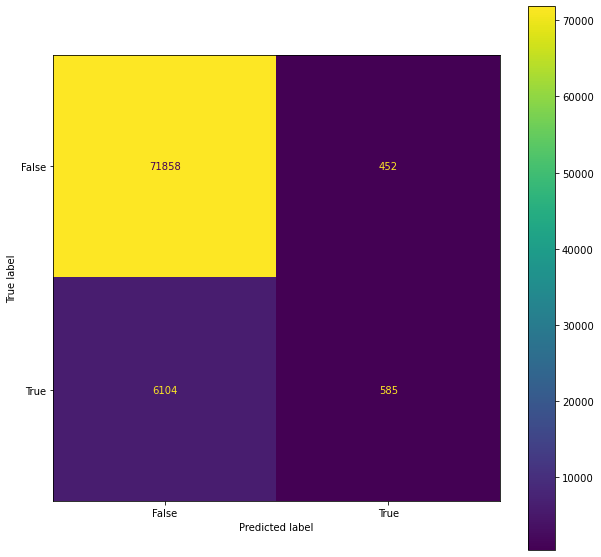

In [157]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, x_test, [str(i) for i in y_test])

У нас достаточно большая ошибка второго рода:(, попробуем избавиться от дисбаланса классов

In [158]:
model_balanced1 = CatBoostClassifier(random_seed=17, 
                                     custom_metric=['AUC', 'Accuracy'], 
                                     auto_class_weights='Balanced', 
                                     use_best_model=True)

# обучим модель
model_balanced1.fit(x_train, y_train,
          cat_features=cat_features,
         eval_set=(x_test, y_test),
         early_stopping_rounds=10,
         plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.122312
0:	learn: 0.6464665	test: 0.6471008	best: 0.6471008 (0)	total: 423ms	remaining: 7m 3s
1:	learn: 0.6121505	test: 0.6133312	best: 0.6133312 (1)	total: 797ms	remaining: 6m 37s
2:	learn: 0.5886376	test: 0.5902268	best: 0.5902268 (2)	total: 1.14s	remaining: 6m 18s
3:	learn: 0.5694858	test: 0.5716894	best: 0.5716894 (3)	total: 1.44s	remaining: 5m 58s
4:	learn: 0.5549610	test: 0.5574746	best: 0.5574746 (4)	total: 1.79s	remaining: 5m 56s
5:	learn: 0.5438486	test: 0.5469297	best: 0.5469297 (5)	total: 2.15s	remaining: 5m 55s
6:	learn: 0.5349604	test: 0.5384536	best: 0.5384536 (6)	total: 2.44s	remaining: 5m 46s
7:	learn: 0.5262034	test: 0.5302130	best: 0.5302130 (7)	total: 2.76s	remaining: 5m 42s
8:	learn: 0.5201295	test: 0.5247565	best: 0.5247565 (8)	total: 3.06s	remaining: 5m 36s
9:	learn: 0.5146646	test: 0.5195543	best: 0.5195543 (9)	total: 3.44s	remaining: 5m 40s
10:	learn: 0.5110100	test: 0.5163959	best: 0.5163959 (10)	total: 3.77s	remaining: 5m 38s
11:	learn: 0

93:	learn: 0.4802892	test: 0.4926016	best: 0.4925959 (92)	total: 38.4s	remaining: 6m 10s
94:	learn: 0.4802807	test: 0.4926024	best: 0.4925959 (92)	total: 38.8s	remaining: 6m 9s
95:	learn: 0.4802792	test: 0.4926023	best: 0.4925959 (92)	total: 39s	remaining: 6m 6s
96:	learn: 0.4802072	test: 0.4925797	best: 0.4925797 (96)	total: 39.5s	remaining: 6m 7s
97:	learn: 0.4801131	test: 0.4925584	best: 0.4925584 (97)	total: 39.9s	remaining: 6m 7s
98:	learn: 0.4800577	test: 0.4925141	best: 0.4925141 (98)	total: 40.4s	remaining: 6m 7s
99:	learn: 0.4799374	test: 0.4924672	best: 0.4924672 (99)	total: 40.8s	remaining: 6m 7s
100:	learn: 0.4798089	test: 0.4924357	best: 0.4924357 (100)	total: 41.1s	remaining: 6m 6s
101:	learn: 0.4797238	test: 0.4924355	best: 0.4924355 (101)	total: 41.6s	remaining: 6m 6s
102:	learn: 0.4796548	test: 0.4924286	best: 0.4924286 (102)	total: 42s	remaining: 6m 5s
103:	learn: 0.4795694	test: 0.4923904	best: 0.4923904 (103)	total: 42.5s	remaining: 6m 6s
104:	learn: 0.4794391	test:

C:\Users\petti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


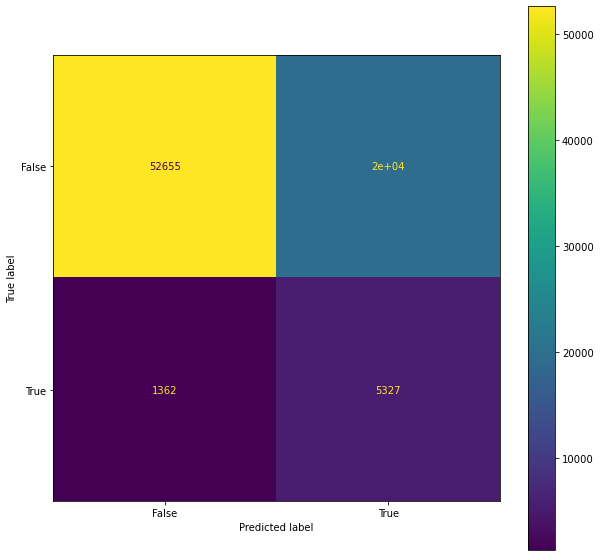

In [159]:
plot_confusion_matrix(model_balanced1, x_test, [str(i) for i in y_test])

Так, ошибка второго рода действительно стала меньше, круто!!

# Что еще можно реализовать:
1. Во-первых следует сразу посмотреть на feature importance.
2. Сделать имт категориальным признаком: сильный недостаток массы, недостаток, норма, избыток, сильный избыток.
3. Мб выкинуть признак расы и/или пола, и посмотреть, как изменится результат.

In [160]:
# Посмотрим на важность признаков
features = dict(zip(model_balanced1.feature_names_, model_balanced1.feature_importances_))
features

{'BMI': 3.5293225650563995,
 'Smoking': 4.194970845343921,
 'AlcoholDrinking': 0.7477859605500866,
 'Stroke': 3.595142508771943,
 'PhysicalHealth': 1.642970829977956,
 'MentalHealth': 2.1318245542586736,
 'DiffWalking': 2.00192191288269,
 'Sex': 8.411233256219305,
 'AgeCategory': 41.9286652439935,
 'Race': 3.393012716521292,
 'Diabetic': 3.736800597366293,
 'PhysicalActivity': 0.2651094691556736,
 'GenHealth': 19.595106596606914,
 'SleepTime': 1.8176127847490104,
 'Asthma': 1.1160191432982245,
 'KidneyDisease': 1.6018318495348343,
 'SkinCancer': 0.2906691657132421}

In [162]:
# Функция для проверки нововведений в модель
def score(df_score):
    x_train, x_test, y_train, y_test = train_test_split(df_score.drop('HeartDisease', axis=1), df_score['HeartDisease'], shuffle=True,
                                                   stratify=df_score['HeartDisease'], random_state=17)

    cat_features = [i for i in df.select_dtypes(include='category')]
    model_balanced = CatBoostClassifier(random_seed=17, 
                                     custom_metric=['AUC', 'Accuracy'], 
                                     auto_class_weights='Balanced', 
                                     use_best_model=True)

    model_balanced.fit(x_train, y_train,
          cat_features=cat_features,
         eval_set=(x_test, y_test),
         early_stopping_rounds=10,
         plot=True)        
    
    plot_confusion_matrix(model_balanced, x_test, [str(i) for i in y_test])
    plt.show()
    
    features = dict(zip(model_balanced.feature_names_, model_balanced.feature_importances_))
    print(features)

Нууууу, я еще немного уменьшила ошибку второго рода, но не думаю, что это изменение стоит считать значительным))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.122312
0:	learn: 0.6464534	test: 0.6470725	best: 0.6470725 (0)	total: 678ms	remaining: 11m 17s
1:	learn: 0.6121624	test: 0.6133227	best: 0.6133227 (1)	total: 1.24s	remaining: 10m 17s
2:	learn: 0.5880258	test: 0.5895668	best: 0.5895668 (2)	total: 1.85s	remaining: 10m 14s
3:	learn: 0.5689228	test: 0.5710135	best: 0.5710135 (3)	total: 2.25s	remaining: 9m 19s
4:	learn: 0.5545698	test: 0.5571940	best: 0.5571940 (4)	total: 2.69s	remaining: 8m 55s
5:	learn: 0.5439792	test: 0.5469845	best: 0.5469845 (5)	total: 3.21s	remaining: 8m 52s
6:	learn: 0.5350970	test: 0.5385628	best: 0.5385628 (6)	total: 3.56s	remaining: 8m 25s
7:	learn: 0.5283575	test: 0.5322189	best: 0.5322189 (7)	total: 3.94s	remaining: 8m 9s
8:	learn: 0.5214923	test: 0.5256997	best: 0.5256997 (8)	total: 4.29s	remaining: 7m 52s
9:	learn: 0.5159732	test: 0.5204998	best: 0.5204998 (9)	total: 4.71s	remaining: 7m 46s
10:	learn: 0.5118424	test: 0.5166225	best: 0.5166225 (10)	total: 5.02s	remaining: 7m 31s
11:	learn

93:	learn: 0.4814987	test: 0.4927553	best: 0.4927553 (93)	total: 38.6s	remaining: 6m 12s
94:	learn: 0.4814247	test: 0.4927026	best: 0.4927026 (94)	total: 39.4s	remaining: 6m 15s
95:	learn: 0.4813681	test: 0.4926842	best: 0.4926842 (95)	total: 40s	remaining: 6m 17s
96:	learn: 0.4812388	test: 0.4926252	best: 0.4926252 (96)	total: 40.7s	remaining: 6m 19s
97:	learn: 0.4811354	test: 0.4926255	best: 0.4926252 (96)	total: 41.4s	remaining: 6m 21s
98:	learn: 0.4810419	test: 0.4926345	best: 0.4926252 (96)	total: 42s	remaining: 6m 22s
99:	learn: 0.4809276	test: 0.4926060	best: 0.4926060 (99)	total: 42.6s	remaining: 6m 23s
100:	learn: 0.4808344	test: 0.4925851	best: 0.4925851 (100)	total: 43s	remaining: 6m 23s
101:	learn: 0.4807849	test: 0.4925749	best: 0.4925749 (101)	total: 43.5s	remaining: 6m 22s
102:	learn: 0.4807334	test: 0.4925765	best: 0.4925749 (101)	total: 44s	remaining: 6m 22s
103:	learn: 0.4806712	test: 0.4925766	best: 0.4925749 (101)	total: 44.5s	remaining: 6m 23s
104:	learn: 0.4806110

C:\Users\petti\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


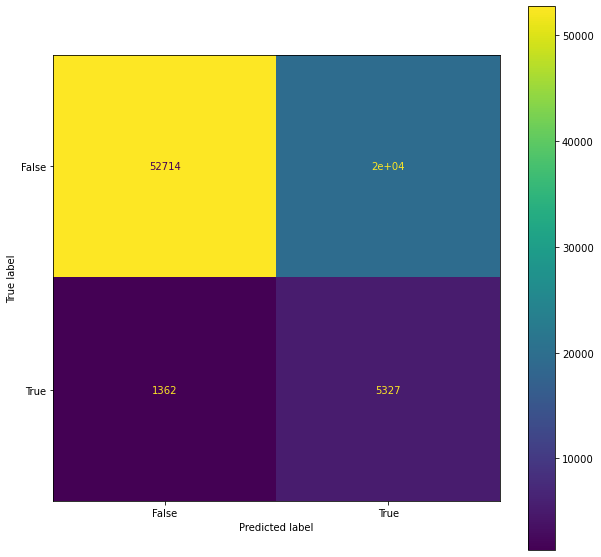

{'Smoking': 4.222721321147775, 'AlcoholDrinking': 0.5515532533632972, 'Stroke': 3.6679624723268924, 'PhysicalHealth': 1.6903758767337276, 'MentalHealth': 0.9763610742113146, 'DiffWalking': 1.6545632969111321, 'Sex': 8.546751623278372, 'AgeCategory': 42.849343954708104, 'Race': 3.6022300960171036, 'Diabetic': 3.7761876716305802, 'GenHealth': 18.85036746068451, 'SleepTime': 2.524200238519093, 'Asthma': 0.9512197933488721, 'KidneyDisease': 1.0189534829230567, 'SkinCancer': 0.4080239341409392, 'BMI_category': 4.709184450055206}


In [165]:
score(df.drop(['PhysicalActivity'], axis=1))

Судя по всему, физическая активность не так уж и сильно влияет на результаты предсказаний, поэтому можно её убрать.
Ну и, наверное, по большей части всё. Я не вижу особых путей для создания новых фичей, которые могли бы привести к крутым результатам.